## Importing libraries

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

## Importing Image names and Labels

In [2]:
# Let's first checkout our labels
import pandas as pd
labels_csv = pd.read_csv("C:\dog-breed-identification\labels.csv")
labels_csv

id                     breed
0      000bec180eb18c7604dcecc8fe0dba07               boston_bull
1      001513dfcb2ffafc82cccf4d8bbaba97                     dingo
2      001cdf01b096e06d78e9e5112d419397                  pekinese
3      00214f311d5d2247d5dfe4fe24b2303d                  bluetick
4      0021f9ceb3235effd7fcde7f7538ed62          golden_retriever
...                                 ...                       ...
10217  ffd25009d635cfd16e793503ac5edef0                    borzoi
10218  ffd3f636f7f379c51ba3648a9ff8254f            dandie_dinmont
10219  ffe2ca6c940cddfee68fa3cc6c63213f                  airedale
10220  ffe5f6d8e2bff356e9482a80a6e29aac        miniature_pinscher
10221  fff43b07992508bc822f33d8ffd902ae  chesapeake_bay_retriever

[10222 rows x 2 columns]

In [3]:
labels_csv.describe()

id               breed
count                              10222               10222
unique                             10222                 120
top     43859e03ccae47c4c8016ff6a851db86  scottish_deerhound
freq                                   1                 126

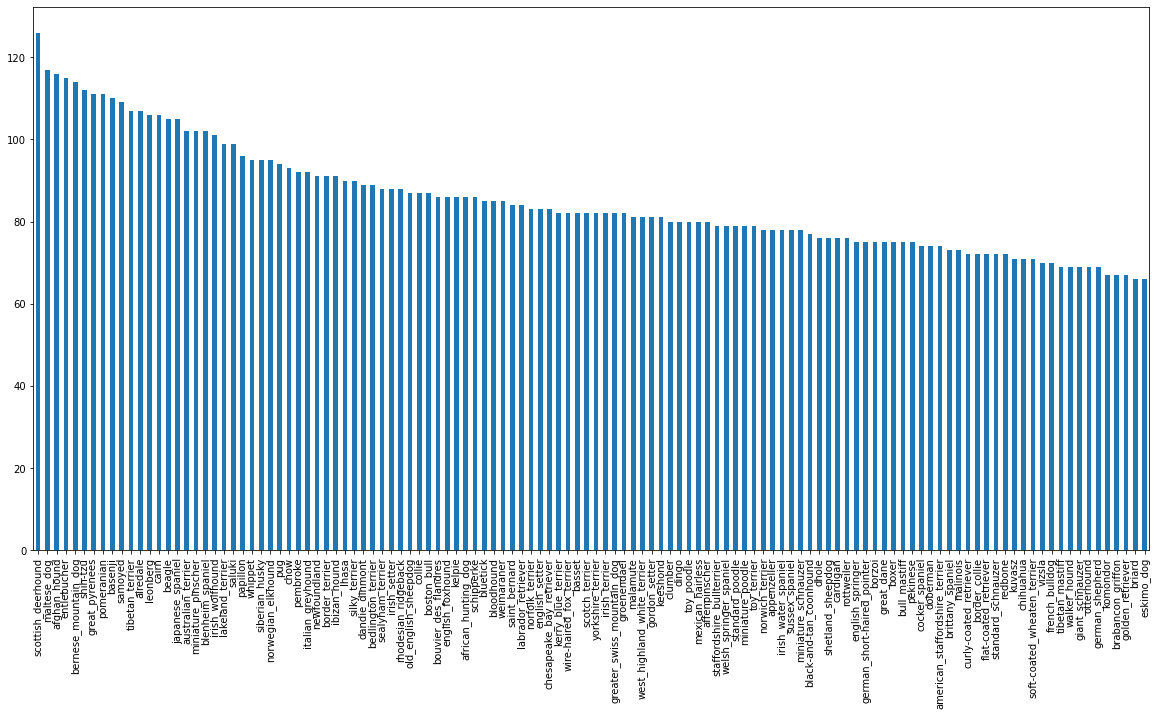

In [4]:
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

In [5]:
# Retrieving filenames
filenames = []
for id in labels_csv["id"]:
  filenames.append(f"C:/dog-breed-identification/train/{id}.jpg")
filenames

['C:/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'C:/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'C:/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'C:/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'C:/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'C:/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'C:/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'C:/dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'C:/dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'C:/dog-breed-identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg',
 'C:/dog-breed-identification/train/004396df1acd0f1247b740ca2b14616e.jpg',
 'C:/dog-breed-identification/train/0067dc3eab0b3c3ef0439477624d85d6.jpg',
 'C:/dog-breed-identification/train/00693b8bc2470375cc744a6391d397ec.jpg',
 'C:/dog-breed-identifica

In [6]:
# Now let's prepare our data as numpy array
import numpy as np
labels = np.array(labels_csv["breed"])

unique_breeds = np.unique(labels)
len(unique_breeds)


120

In [7]:
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[0:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

## Let's Fit our data into train and validation

In [8]:
from sklearn.model_selection import train_test_split

X = filenames
y = boolean_labels

np.random.seed(42)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
print(len(X_train), len(X_val), len(y_train), len(y_val))

8177 2045 8177 2045


## Turning Images into tensors

In [9]:
from matplotlib.pyplot import imread
image = imread(filenames[0])
image.shape

(375, 500, 3)

In [10]:
# Now it's time to fetch images and preprocess them
# Create a function for preprocessing images

IMG_SIZE = 224

def process_image(image_path, img_size = IMG_SIZE):
  """
  Takes an image file path and turns the image into tensor
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the image into numerical tensor with 3 color channels(Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the color channel values from 0-255 to 0-1 values(Normalization)
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[img_size, img_size])
  return image


In [11]:
# Create a function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path and its label and processes it into tuples of (image, label)
  """

  image = process_image(image_path)
  return image, label

In [12]:
# Let's turn our data into batches
# Define a batch size, a batch size of 32 is generally good
BATCH_SIZE = 32

def create_data_batches(X, y=None, valid_data=False, test_data=False):
  """
  Creates batches of (image(X), label(y)) pair
  Shuffles the data if it's training data but not shuffle if validation data
  also accepts test data as input but no labels
  """
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.contant(X))) #only file_paths no labels
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  elif valid_data:
    print("Creating valid data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                              tf.constant(y)))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  else:
    print("Creating train data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                              tf.constant(y)))
    data = data.shuffle(buffer_size=len(X))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

In [13]:
# Now let's use upper function to create data batches of training and validation data
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)
  

Creating train data batches...
Creating valid data batches...


In [14]:
# checkout different attributes of our data
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing our Data

In [15]:
# Let's make a function to visualize our batches
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 to display 25 images
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")
    

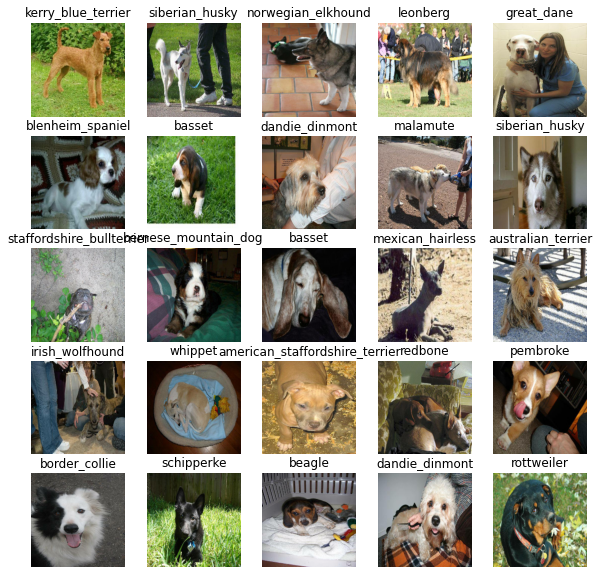

In [16]:
import matplotlib.pyplot as plt
# Lets use the function to visualize our training data batches
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

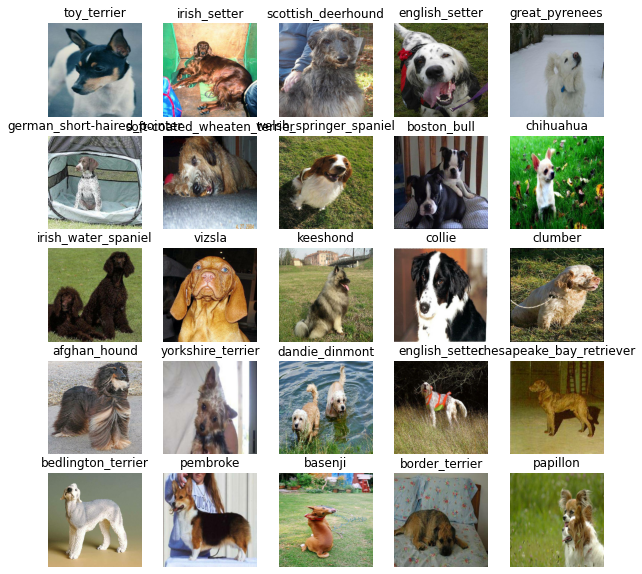

In [17]:
# Lets visualize our validation data batches
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building our Model

# Before Building a model we have to define a few things

*   The input shape (our images shape, in the form of tensors) to our model. 
*   The output shape (image labels in, in the form of tensors) to our model.
*   The URL of model we want to use.


In [18]:
IMG_SIZE = 224
# Setup input shape of our model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # Batch, Height, Witdh, Color Channel
# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)
# Setup model URL form TensorFlow hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [19]:
# Create a function which builds Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url = MODEL_URL):
  print("Building model with: ", MODEL_URL)

  # Setup model layers
  model = tf.keras.Sequential([hub.KerasLayer(MODEL_URL), #Layer 1 (input layer)
                               tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                                                     activation="softmax") #Layer 2 (output layer)
                               ])
  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)
  
  return model

In [20]:
model = create_model()
model.summary()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


# Creating Tensorboard Callbacks

  Callbacks are helper functions a model can use during training to do such things such as saving its progress, check its progress or stop traing early if a model stops improving.
  We'll create two callbacks, one for Tensoboard which helps track our model from training from too long.

In [21]:
# Load Tensoboard notebook extension
%load_ext tensorboard

In [43]:
import datetime
import os
# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing Tensoboard logs
  logdir = "C:/dog-breed-identification/logs"
                        
  return tf.keras.callbacks.TensorBoard(logdir)

In [44]:
# Create early stopping callback (Prevents our model from overfitting)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Saving and reloading a Trained Model

In [48]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a module directory and appends a suffix (string)
  """
  # Saves a model in a models directory pathname with current time
  modeldir = "C:/dog-breed-identification/models"
  model_path = modeldir +"-" + suffix +".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [49]:
# Create a function to load a trained model
def load_model(model_path):
  """
  loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

## Training a model (on a subset of data)

In [50]:
NUM_EPOCHS = 100
# Let's create a function which trains model and returns a model
def train_model():
  """
  Trains a given a model and returns the trained version of model.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model


In [51]:
# Fit the model to the data

model = train_model()
save_model(model, suffix="Full-DataSet-Mobilenet-V2")

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
  2/256 [..............................] - ETA: 13:31 - loss: 5.5490 - accuracy: 0.0000e+00WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (3.129246). Check your callbacks.


256/256 [==============================] - 50s 195ms/step - loss: 1.4908 - accuracy: 0.6440 - val_loss: 0.7124 - val_accuracy: 0.7824
Epoch 2/100
256/256 [==============================] - 39s 154ms/step - loss: 0.4196 - accuracy: 0.8797 - val_loss: 0.6649 - val_accuracy: 0.8020
Epoch 3/100
256/256 [==============================] - 39s 154ms/step - loss: 0.2365 - accuracy: 0.9385 - val_loss: 0.6563 - val_accuracy: 0.7985
Epoch 4/100
256/256 [==============================] - 40s 156ms/step - loss: 0.1510 - accuracy: 0.9678 - val_loss: 0.6580 - val_accuracy: 0.8059
Epoch 5/100
256/256 [==============================] - 40s 158ms/step - loss: 0.1029 - accuracy: 0.9820 - val_loss: 0.6643 - val_accuracy: 0.8064
Epoch 6/100
256/256 [==============================] - 41s 160ms/step - loss: 0.0723 - accuracy: 0.9901 - val_loss: 0.6595 - val_accuracy: 0.8137
Epoch 7/100
256/256 [==============================] - 42s 162ms/step - loss: 0.0550 - accuracy: 0.9957 - val_loss: 0.6808 - val_accurac

'C:/dog-breed-identification/models-Full-DataSet-Mobilenet-V2.h5'

## Checking the TensorBoard logs
   It will access the log directory which is automatically created by callbacks

In [53]:
%tensorboard --logdir C:/dog-breed-identification/logs

Reusing TensorBoard on port 6006 (pid 12200), started 0:01:35 ago. (Use '!kill 12200' to kill it.)

In [ ]:

# Loading a model
loaded_model = load_model("C:/dog-breed-identification/models-Full-DataSet-Mobilenet-V2.h5")


Loading saved model from: /content/drive/My Drive/Dog Vision/Extracted Dog Breed/models/20200706-07421594021356-Full-DataSet-Mobilenet-V2.h5


## making and evaluating predictions using a trined model

In [54]:
# Make predictions on validation data (not used to train model)
predictions = model.predict(val_data, verbose=1)
predictions

64/64 [==============================] - 8s 120ms/step


array([[1.0185415e-08, 6.3591493e-10, 2.1311406e-07, ..., 1.8072514e-07,
        1.2082679e-05, 2.8793402e-06],
       [3.4072492e-08, 1.1759976e-06, 1.2810127e-08, ..., 5.6880303e-08,
        7.6685449e-09, 3.2454116e-06],
       [8.1865892e-08, 1.0159040e-06, 9.6643362e-08, ..., 9.6146114e-06,
        4.0810614e-06, 3.8816120e-07],
       ...,
       [5.9539911e-09, 6.7951692e-06, 2.8315323e-08, ..., 6.6184827e-09,
        2.4525118e-06, 4.1034732e-06],
       [5.7932009e-10, 1.4113115e-08, 2.4728726e-09, ..., 3.6376910e-10,
        4.0346560e-08, 2.6561581e-10],
       [1.9766042e-06, 9.5367358e-09, 4.7653609e-07, ..., 4.0144876e-08,
        1.8626492e-08, 2.8074847e-09]], dtype=float32)

In [55]:
# Lets create a function which predicts dog breed
def predict_dog_breed(index):
  print(predictions[index])
  print(f"Max value (probability of predictions): {np.max(predictions[index])}")
  print(f"Sum: {np.sum(predictions[index])})")
  print(f"max index: {np.argmax(predictions[index])}")
  print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """  
  return unique_breeds[np.argmax(prediction_probabilities)]

# Now we need to unbatch our data to explore it

In [56]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)


In [57]:
val_images[1]

array([[[0.2772842 , 0.7439509 , 0.524343  ],
        [0.2632589 , 0.7299256 , 0.51031774],
        [0.28618792, 0.74501145, 0.5293252 ],
        ...,
        [0.4726279 , 0.6765495 , 0.53537303],
        [0.47743532, 0.67351377, 0.5362588 ],
        [0.47331935, 0.65763307, 0.52429974]],

       [[0.28438783, 0.7510545 , 0.5314467 ],
        [0.2790152 , 0.7456819 , 0.52607405],
        [0.26632386, 0.7251474 , 0.50946116],
        ...,
        [0.45193765, 0.64751136, 0.49908698],
        [0.46358547, 0.65966386, 0.5137492 ],
        [0.4981443 , 0.6942227 , 0.54912466]],

       [[0.27567998, 0.74234664, 0.5227388 ],
        [0.256145  , 0.72281164, 0.5032038 ],
        [0.271742  , 0.7305655 , 0.5148792 ],
        ...,
        [0.4723897 , 0.65613234, 0.49047473],
        [0.46480805, 0.6530433 , 0.494255  ],
        [0.45706362, 0.65351063, 0.5064159 ]],

       ...,

       [[0.14145195, 0.56741416, 0.8719583 ],
        [0.2176264 , 0.6449975 , 0.96271425],
        [0.19433637, 0

In [58]:
# Lets create a function to plot images with the prediction
def plot_pred(prediction_probabilities, labels, images, n=1): 
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title according to prediction right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Change plot title to be predicted, probability of predictions and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
            color=color)


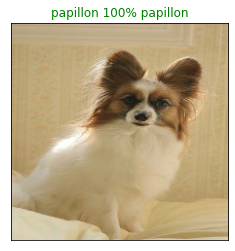

In [59]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=60)

In [60]:
s = 0
for i in range(0, 2045):
  if get_pred_label(predictions[i]) != val_labels[i]:
    s = s + 1
print(s)

388


In [61]:
len(predictions)

2045